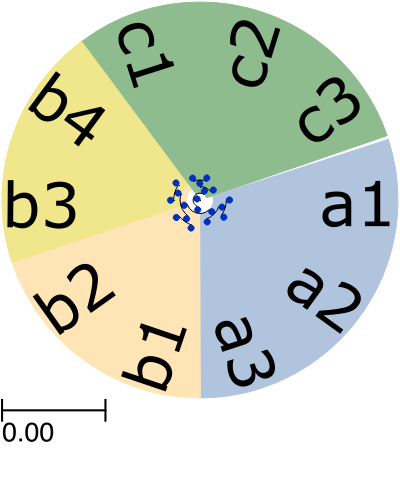


            /-a1
         /-|
      /-|   \-a2
     |  |
     |   \-a3
   /-|
  |  |      /-b1
  |  |   /-|
  |  |  |   \-b2
  |   \-|
--|     |   /-b3
  |      \-|
  |         \-b4
  |
  |      /-c1
  |   /-|
   \-|   \-c2
     |
      \-c3


In [14]:
from ete3 import Tree, faces, AttrFace, TreeStyle, NodeStyle
from IPython.display import Image, display

def layout(node):
    if node.is_leaf():
        N = AttrFace("name", fsize=30)
        faces.add_face_to_node(N, node, 0, position="aligned")

def get_example_tree():

    # Set dashed blue lines in all leaves
    nst1 = NodeStyle()
    nst1["bgcolor"] = "LightSteelBlue"
    nst2 = NodeStyle()
    nst2["bgcolor"] = "Moccasin"
    nst3 = NodeStyle()
    nst3["bgcolor"] = "DarkSeaGreen"
    nst4 = NodeStyle()
    nst4["bgcolor"] = "Khaki"


    t = Tree("((((a1,a2),a3), ((b1,b2),(b3,b4))), ((c1,c2),c3));")
    for n in t.traverse():
        n.dist = 0

    n1 = t.get_common_ancestor("a1", "a2", "a3")
    n1.set_style(nst1)
    n2 = t.get_common_ancestor("b1", "b2", "b3", "b4")
    n2.set_style(nst2)
    n3 = t.get_common_ancestor("c1", "c2", "c3")
    n3.set_style(nst3)
    n4 = t.get_common_ancestor("b3", "b4")
    n4.set_style(nst4)
    ts = TreeStyle()
    ts.layout_fn = layout
    ts.show_leaf_name = False

    ts.mode = "c"
    ts.root_opening_factor = 1
    return t, ts

if __name__ == "__main__":
    t, ts = get_example_tree()
    t.render("node_background.png", w=400, tree_style=ts)
    display(Image(filename='node_background.png'))
    t.show(tree_style=ts)
    print (t)

In [16]:
from ete3 import Tree
t =  Tree("((((((4, e), i), o),h), u), ((3, 4), (i, june)));")
# we annotate the tree using external data
colors = {"a":"red", "e":"green", "i":"yellow",
          "o":"black", "u":"purple", "4":"green",
          "3":"yellow", "1":"white", "5":"red",
          "june":"yellow"}
for leaf in t:
    leaf.add_features(color=colors.get(leaf.name, "none"))
    leaf.add_features(num= "num: "+str(len(colors.get(leaf.name, "none"))))
print t.get_ascii(attributes=["name", "color","num"], show_internal=False)
t.show()


                  /-4, green, num: 5
               /-|
            /-|   \-e, green, num: 5
           |  |
         /-|   \-i, yellow, num: 6
        |  |
      /-|   \-o, black, num: 5
     |  |
   /-|   \-h, none, num: 4
  |  |
  |   \-u, purple, num: 6
--|
  |      /-3, yellow, num: 6
  |   /-|
  |  |   \-4, green, num: 5
   \-|
     |   /-i, yellow, num: 6
      \-|
         \-june, yellow, num: 6


In [ ]:
from ete3 import Tree
t = Tree()
t.populate(50)

node2leaves = t.get_cached_content()
print t.get_ascii(attributes=["name", "color","num"], show_internal=False)
# lets now print the size of each node without the need of
# recursively traverse
for n in t.traverse():
    print "node %s contains %s tips" %(n.name, len(node2leaves[n]))

# Automatic tree annotation using NCBI taxonomy
NCBI taxonomy annotation consists of adding additional information to any internal a leaf node in a give user tree. Only an attribute containing the taxid associated to each node is required for the nodes in the query tree. The annotation process will add the following features to the nodes:

- sci_name
- taxid
- named_lineage
- lineage
- rank

In [ ]:
from ete3 import PhyloTree

# load the whole leaf name as species taxid
tree = PhyloTree('((9606, 9598), 10090);', sp_naming_function=lambda name: name)
tax2names, tax2lineages, tax2rank = tree.annotate_ncbi_taxa()

# split names by '|' and return the first part as the species taxid
tree = PhyloTree('((9606|protA, 9598|protA), 10090|protB);', sp_naming_function=lambda name: name.split('|')[0])
tax2names, tax2lineages, tax2rank = tree.annotate_ncbi_taxa()

print tree.get_ascii(attributes=["name", "sci_name", "taxid"])


#                                             /-9606|protA, Homo sapiens, 9606
#                          /, Homininae, 207598
#-, Euarchontoglires, 314146                  \-9598|protA, Pan troglodytes, 9598
#                         |
#                          \-10090|protB, Mus musculus, 10090

## Alternatively, you can also use the NCBITaxa.annotate_tree() function to annotate a custom tree instance.



In [ ]:
from ete3 import Tree, NCBITaxa
ncbi = NCBITaxa()
tree = Tree()
#tree.populate(50)

ncbi.annotate_tree(tree, taxid_attr="name")

## Loading PhyloXML projects from files



In [ ]:
from ete3 import Phyloxml
project = Phyloxml()
project.build_from_file("tax_ncbi.xml")

# Each tree contains the same methods as a PhyloTree object
for tree in project.get_phylogeny():
    print tree
    # you can even use rendering options
    #tree.show()
    # PhyloXML features are stored in the phyloxml_clade attribute
    for node in tree:
        #node.add_features(size=len(node))
 
        print "Node name:", node.name
        for seq in node.phyloxml_clade.get_sequence():
            for domain in seq.domain_architecture.get_domain():
                domain_data = [domain.valueOf_, domain.get_from(), domain.get_to()]
                print "  Domain:", '\t'.join(map(str, domain_data))

                
#tree.show()

## Getting NCBI species tree topology
### annotate the tree

1591188


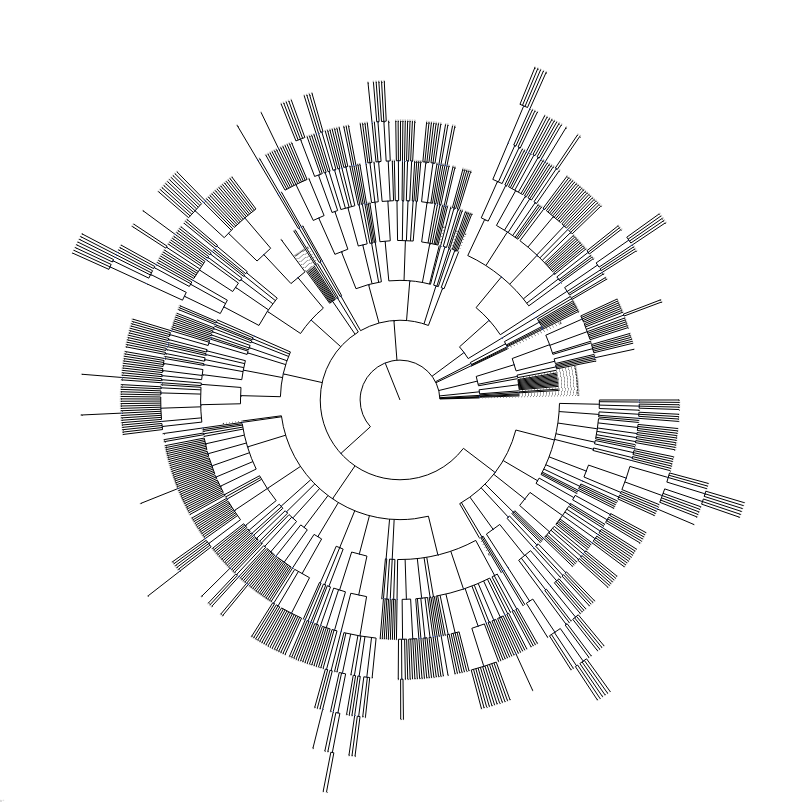

In [1]:
from ete3 import NCBITaxa, Tree, TreeStyle
from IPython.display import Image, display

ncbi = NCBITaxa()
with open("ncbi_tax_id.csv") as f:
    tax_list=f.read().splitlines()
print (len(tax_list))    
#print (id2lineage(9927))
# tax_list=[1979279, 9927,9598, 10090,9606, 7707, 8782,1979366]
# tax_list=[1980754, 1980752, 1979878, 1979847, 1979539, 1979538, 1979537, 1979536]
tree = ncbi.get_topology(tax_list[:1000],intermediate_nodes=False)
ncbi.annotate_tree(tree, taxid_attr='name')
#print (tree)
#print tree.get_ascii(attributes=["sci_name", "rank","name"])


# Create an empty TreeStyle
ts = TreeStyle()
# Set our custom layout function
#ts.layout_fn = layout
# Draw a tree
ts.mode = "c"
# show the tree in ETE browser
tree.show(tree_style=ts)
tree.render("ncbi_db.png", w=800, tree_style=ts)
display(Image("ncbi_db.png"))



## All descendants of Cellular organisms

In [37]:
from ete3 import *
#descendants = ncbi.get_descendant_taxa('13157')
#print ncbi.translate_to_names(descendants)
tree = ncbi.get_descendant_taxa('78173', return_tree=True)
print tree.get_ascii(attributes=['taxid'])



           /-710036
          |
          |--710029
          |
          |--710030
          |
          |--710031
          |
          |--710032
     /236013
    |     |--710033
    |     |
    |     |--710034
    |     |
    |     |--710035
    |     |
    |     |--710050
    |     |
    |      \-236024
    |
    |      /-1291523
    |     |
    |     |--1281792
    |     |
    |-710072-1281812
    |     |
    |     |--710040
    |     |
    |      \-710041
    |
    |      /-1291524
    |     |
    |     |--1291525
    |     |
    |     |--1291526
    |     |
    |     |--1291527
    |     |
    |     |--1291528
    |     |
    |     |--1291530
    |     |
    |     |--1291531
    |     |
    |     |--888509
    |     |
    |-710056-1291529
    |     |
    |     |--1281814
    |     |
    |     |--1281816
    |     |
    |     |--1281817
    |     |
    |     |--710020
    |     |
    |     |--710021
    |     |
    |     |--710022
    |     |
    |     |--710023
    |     |
    

In [ ]:
from ete3 import nexml, Nexml
nexml_tree = nexml.NexmlTree("((hello, nexml):1.51, project):0.6;")
tree_collection =  nexml.get_trees()[0]

tree_collection.add_tree(nexml_tree)
nexml_tree.show()

## Pie chart Face and Barchart Face

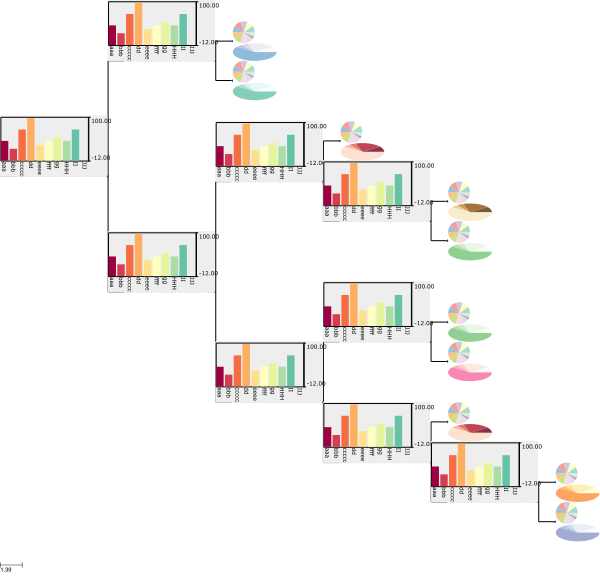

In [15]:
import sys
import random
from ete3 import Tree, faces, TreeStyle, COLOR_SCHEMES
from IPython.display import Image, display

schema_names = COLOR_SCHEMES.keys()

def layout(node):
    #print (node.name)
    if node.is_leaf():
        F= faces.PieChartFace([10,10,10,10,10,10,10,10,10,4,6],
                              colors=COLOR_SCHEMES["set3"],
                              width=50, height=50)
        F.border.width = None
        F.opacity = 0.8
        faces.add_face_to_node(F,node, 0, position="branch-right")

        F= faces.PieChartFace([10,20,5,5,60],
                              colors=COLOR_SCHEMES[random.sample(schema_names, 1)[0]],
                              width=100, height=40)
        F.border.width = None
        F.opacity = 0.8
        faces.add_face_to_node(F,node, 0, position="branch-right")
    else:
        F= faces.BarChartFace([40,20,70,100,30,40,50,40,70,-12], min_value=-12,
                              colors=COLOR_SCHEMES["spectral"],
                              labels = "aaa,bbb,cccccc,dd,eeee,ffff,gg,HHH,II,JJJ,KK".split(","),
                              label_fsize=10, scale_fsize=10)
        faces.add_face_to_node(F,node, 0, position="branch-top")
        F.background.color = "#eee"

def get_example_tree():
    t = Tree()
    ts = TreeStyle()
    ts.layout_fn = layout
    ts.mode = "r"
    ts.show_leaf_name = False
    t.populate(10)
    for leaf in t:
      leaf.add_features(num= "num: "+str(len(leaf)))
    
    return t, ts

if __name__ == '__main__':
    t, ts = get_example_tree()
    
    t.render("piechart.png", w=600, tree_style=ts)
    display(Image(filename='piechart.png'))
    t.show(tree_style=ts)


In [ ]:
import os
os.system('python tree1.py')

In [ ]:
import sys
import random
from ete3 import Tree, faces, TreeStyle, COLOR_SCHEMES

schema_names = COLOR_SCHEMES.keys()

def layout(node):
    if not node.is_leaf():
        size = random.randint(20,50)
        F= faces.PieChartFace([10,20,60,10],
                              colors=COLOR_SCHEMES[random.sample(schema_names, 1)[0]],
                              width=size, height=size)
        F.border.width = None
        F.opacity = 0.6
        faces.add_face_to_node(F,node, 0, position="float")

def get_example_tree():
    t = Tree()
    ts = TreeStyle()
    ts.layout_fn = layout
    ts.mode = "c"
    ts.show_leaf_name = True
    ts.min_leaf_separation = 15
    t.populate(100)
    return t, ts

if __name__ == '__main__':
    t, ts = get_example_tree()
    t.show(tree_style=ts)
    #t.render("float_piechart.png", tree_style=ts)


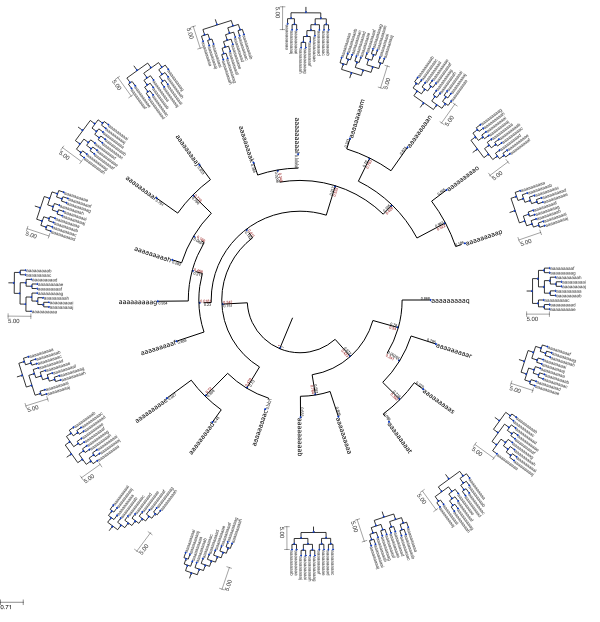

In [20]:
import random
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, TreeFace
from IPython.display import Image, display

# Tree Style used to render small trees used as leaf faces
small_ts = TreeStyle()
small_ts.show_leaf_name = True
small_ts.scale = 10

def layout(node):
    if node.is_leaf():
        # Add node name to laef nodes
        N = AttrFace("name", fsize=14, fgcolor="black")
        faces.add_face_to_node(N, node, 0)

        t = Tree()
        t.populate(10)

        T = TreeFace(t, small_ts)
        # Let's make the sphere transparent
        T.opacity = 0.8
        # And place as a float face over the tree
        faces.add_face_to_node(T, node, 1, position="aligned")

def get_example_tree():
    # Random tree
    t = Tree()
    t.populate(20, random_branches=True)

    # Some random features in all nodes
    for n in t.traverse():
        n.add_features(weight=random.randint(0, 50))

    # Create an empty TreeStyle
    ts = TreeStyle()

    # Set our custom layout function
    ts.layout_fn = layout

    # Draw a tree
    ts.mode = "c"

    # We will add node names manually
    ts.show_leaf_name = False
    # Show branch data
    ts.show_branch_length = True
    ts.show_branch_support = True
    return t, ts

if __name__ == "__main__":
    t, ts = get_example_tree()
    t.render("tree_faces.png", w=600, dpi=300, tree_style=ts)
    display(Image('tree_faces.png'))
    #t.show(tree_style=ts)

